# Imports

In [1]:
import torch
from torch import nn
import torch.nn.functional as F

import pandas as pd
import numpy as np

from tqdm.auto import tqdm

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

# from plotly_resampler import FigureWidgetResampler

import os
import typing as tp
import numpy.typing as npt

import wandb
import lightning as L
from lightning.pytorch.utilities.types import STEP_OUTPUT
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.loggers import WandbLogger
from lightning.pytorch.callbacks import ModelCheckpoint
import importlib
# os.environ['KMP_DUPLICATE_LIB_OK']='True'

/home/motatasher/miniconda3/envs/HS4/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext autoreload
%autoreload 2


In [3]:
import visualizatoin
import Model
import Maps

importlib.reload(visualizatoin)
importlib.reload(Model)
importlib.reload(Maps)

import visualizatoin
from Model import *
import Maps

# Model

In [4]:
import torch
from torch import nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)
    


class UNet(nn.Module):
    def __init__(self, n_channels, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 32))
        self.down1 = (Down(32, 64))
        self.down2 = (Down(64, 128))
        factor = 2 if bilinear else 1
        self.down3 = (Down(128, 256 // factor))

        self.up1 = (Up(256, 128 // factor, bilinear))
        self.up2 = (Up(128, 64 // factor, bilinear))
        self.up3 = (Up(64, 32, bilinear))
        self.outc = (OutConv(32, 1))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x = self.up1(x4, x3)
        x = self.up2(x, x2)
        x = self.up3(x, x1)
        logits = self.outc(x)
        return logits


# Losses

In [5]:
def mse_loss(pred, target, cells):
    return nn.MSELoss()(pred[~torch.isinf(target)], target[~torch.isinf(target)])


def mae_loss(pred, target, cells):
    return nn.L1Loss()(pred[~torch.isinf(target)], target[~torch.isinf(target)])


def piecewise_mae_loss(pred, target, cells, min_val, max_val, alpha1=1, alpha2=1):
    loss = 0
    for p, t in zip(pred[~torch.isinf(target)].flatten(), target[~torch.isinf(target)].flatten()):
        if p < min_val:
            loss += alpha1 * abs(p - t)
        elif p > max_val:
            loss += alpha2 * abs(p - t)
        else:
            loss += abs(p - t)
    return loss / len(pred.flatten())


def lossgrad_loss(pred, target, fake=None):
    kernel = torch.tensor([[1, 0, -1],
                            [2, 0, -2],
                            [1, 0, -1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    
    kernel = kernel.to(pred.device)
    
    pred_grad_x = F.conv2d(pred.unsqueeze(0), kernel, padding=1)
    target_grad_x = F.conv2d(target.unsqueeze(0), kernel, padding=1)

    sobel_kernel_vertical = kernel.transpose(2, 3)
    
    pred_grad_y = F.conv2d(pred.unsqueeze(0), sobel_kernel_vertical, padding=1)
    target_grad_y = F.conv2d(target.unsqueeze(0), sobel_kernel_vertical, padding=1)
    
    x_ind = ~torch.isinf(target_grad_x) & ~torch.isnan(target_grad_x)
    y_ind = ~torch.isinf(target_grad_y) & ~torch.isnan(target_grad_y)

    grad_error_x = torch.abs(pred_grad_x[x_ind] - target_grad_x[x_ind])
    grad_error_y = torch.abs(pred_grad_y[y_ind] - target_grad_y[y_ind])

    loss = (grad_error_x.sum() + grad_error_y.sum()) / (len(grad_error_x) + len(grad_error_y))
    return loss


# Dataset

In [6]:
path = './AlekSet/train'
files = os.listdir(path)
def GetPath(name : int | str):
    if type(name) is int:
        return np.load(os.path.join(path, files[name]), mmap_mode='c')
    else:
        return np.load(os.path.join(path, name), mmap_mode='c')

In [7]:
class GridData(Dataset):
    def __init__(self, path, img_size=64):
        self.img_size = img_size

        self.maps = torch.tensor(np.load(os.path.join(path, 'maps.npy')))
        self.starts = torch.tensor(np.load(os.path.join(path, 'starts.npy')))
        self.goals = torch.tensor(np.load(os.path.join(path, 'goals.npy')))
        self.targets = torch.tensor(np.load(os.path.join(path, 'abs.npy')))

    def __len__(self):
        return len(self.maps)
    
    def get_with_all(self, idx):
        cells = self.maps[idx, 0]
        positions_map = self.goals[idx, 0]
        start_map = self.starts[idx, 0]
        shape = (-1, self.img_size, self.img_size)
        target = self.targets[idx, 0]
        return cells.reshape(shape).type(torch.float), \
            positions_map.reshape(shape).type(torch.float), \
                start_map.reshape(shape).type(torch.float), \
                    target.reshape(shape).type(torch.float)
    
    def __getitem__(self, idx):
        cells = self.maps[idx, 0]
        positions_map = self.goals[idx, 0]
        shape = (-1, self.img_size, self.img_size)
        target = self.targets[idx, 0]
        return cells.reshape(shape).type(torch.float), \
            positions_map.reshape(shape).type(torch.float), \
                target.reshape(shape).type(torch.float)

In [8]:
dataset_dir = './AlekSet'
batch_size = 4
max_epochs = 1000
learning_rate = 1e-4
weight_decay = 0.0
limit_train_batches = 500
limit_val_batches = 100
proj_name = 'motatasher_HS2_AlekSet'
run_name = 'default'

In [9]:
train_data = GridData(
        path=f'{dataset_dir}/train',
    )
val_data = GridData(
        path=f'{dataset_dir}/val',
    )
resolution = (train_data.img_size, train_data.img_size)

In [10]:
torch.manual_seed(42)
train_dataloader = DataLoader(
        train_data, 
        batch_size=batch_size,
        shuffle=True, 
        num_workers=2,
        # num_workers=multiprocessing.cpu_count(), freezes jupyter notebook
        pin_memory=True
    )
val_dataloader = DataLoader(
        val_data, 
        batch_size=batch_size,
        shuffle=False, 
        num_workers=2,
        # num_workers=multiprocessing.cpu_count(), freezes jupyter notebook
        pin_memory=True
    )
samples = next(iter(val_dataloader))

# Training

In [11]:
torch.serialization.add_safe_globals([nn.Conv2d])
torch.serialization.add_safe_globals([nn.Sequential])
torch.serialization.add_safe_globals([set])
torch.serialization.add_safe_globals([nn.BatchNorm2d])
torch.serialization.add_safe_globals([nn.ReLU])
torch.serialization.add_safe_globals([nn.MaxPool2d])
torch.serialization.add_safe_globals([nn.ConvTranspose2d]) 
 
torch.serialization.add_safe_globals([DoubleConv])
torch.serialization.add_safe_globals([Down])
torch.serialization.add_safe_globals([Up])
torch.serialization.add_safe_globals([OutConv])
torch.serialization.add_safe_globals([UNet])

torch.serialization.add_safe_globals([mse_loss])

In [12]:
model : UNet = torch.load('checkpoints/mode=0-epoch=2999-timestr=0.ckpt', weights_only=True)['hyper_parameters']['model']

In [13]:
optimizer = torch.optim.AdamW(model.parameters())
loss_func = lossgrad_loss

In [14]:
class UnetLit(L.LightningModule):
    def __init__(self, model: nn.Module, mode: str='f', learning_rate: float=1e-4,
                 weight_decay: float=0.0, loss = mse_loss) -> None:
        super().__init__()
        self.save_hyperparameters()

        self.model = model
        self.mode = mode
        self.loss = loss
        self.k = 64 * 64 if mode == 'h' else 1

        self.learning_rate = learning_rate
        self.weight_decay = weight_decay

    def training_step(
        self, batch: tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor], batch_idx: int
    ) -> STEP_OUTPUT:
        cells, positions_map, target = batch
        inputs = torch.cat([cells, positions_map], dim=1)
        predictions = self.model(inputs)
        loss = self.loss(predictions, target, cells)
        self.log(f'train_loss', loss, on_step=False, on_epoch=True)
        return loss

    def validation_step(
        self, batch: tuple[torch.Tensor, torch.Tensor, torch.Tensor], batch_idx: int
    ) -> STEP_OUTPUT | None:
        cells, positions_map, target = batch
        inputs = torch.cat([cells, positions_map], dim=1)
        predictions = self.model(inputs)
        loss = self.loss(predictions, target, cells)
        self.log(f'val_loss', loss, on_step=False, on_epoch=True)
        return loss

    def configure_optimizers(self) -> dict[str, tp.Any]:
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer, max_lr=self.learning_rate, total_steps=self.trainer.estimated_stepping_batches
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": scheduler
        }

In [15]:
class PathLogger(L.Callback):
    def __init__(self, val_batch, num_samples=10, mode='f'):
        super().__init__()
        cells, positions_map, target = val_batch[:num_samples]
        inputs = torch.cat([cells, positions_map], dim=1)
        self.val_samples = inputs[:num_samples]

    def on_validation_epoch_end(self, trainer, lightning_module):
        val_samples = self.val_samples.to(device=lightning_module.device)
        prediction = lightning_module.model(val_samples)
        if lightning_module.mode == 'h':
            prediction = prediction * 64 * 64

        trainer.logger.experiment.log({
            'data': [wandb.Image(x) for x in self.val_samples],
            'predictions': [wandb.Image(x) for x in torch.cat([val_samples, prediction], dim=1)]
        })

In [16]:
train_data = GridData(
        path=f'{dataset_dir}/train',
    )
val_data = GridData(
        path=f'{dataset_dir}/val',
    )
resolution = (train_data.img_size, train_data.img_size)

In [17]:
torch.manual_seed(42)
train_dataloader = DataLoader(
        train_data, 
        batch_size=batch_size,
        shuffle=True, 
        num_workers=2,
        pin_memory=True
    )
val_dataloader = DataLoader(
        val_data, 
        batch_size=batch_size,
        shuffle=False, 
        num_workers=2,
        pin_memory=True
    )
samples = next(iter(val_dataloader))

In [18]:
torch.manual_seed(42)
callback = PathLogger(samples)
checkpoints = ModelCheckpoint(dirpath='checkpoints_Alek/', filename='{mode}-{epoch}-{timestr}', every_n_epochs=50)
wandb_logger = WandbLogger(project=proj_name, name=f'{run_name}_{"h"}', log_model='all')

model : UNet = torch.load('checkpoints/mode=0-epoch=2999-timestr=0.ckpt', weights_only=True)['hyper_parameters']['model']
lit_module = UnetLit(
        model=model,
        mode='h',
        learning_rate=learning_rate,
        weight_decay=weight_decay
    )

trainer = L.Trainer(
        logger=wandb_logger,
        accelerator="auto",
        max_epochs=max_epochs,
        deterministic=False,
        limit_train_batches=limit_train_batches,
        limit_val_batches=limit_val_batches,
        callbacks=[callback, checkpoints],
    )

/home/motatasher/miniconda3/envs/HS4/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
Trainer will use only 1 of 7 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=7)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[[60 36]] [[ 9 47]]


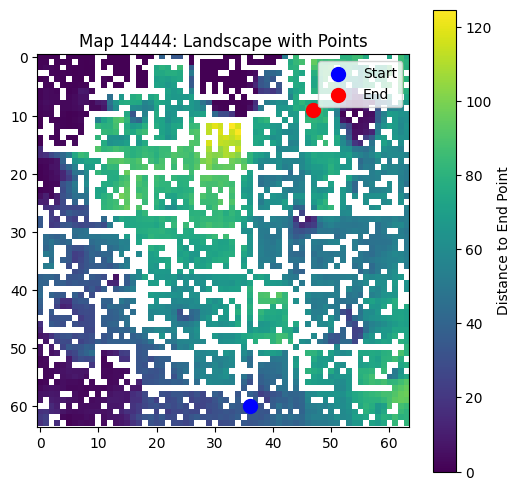

[[60 36]] [[ 9 47]]


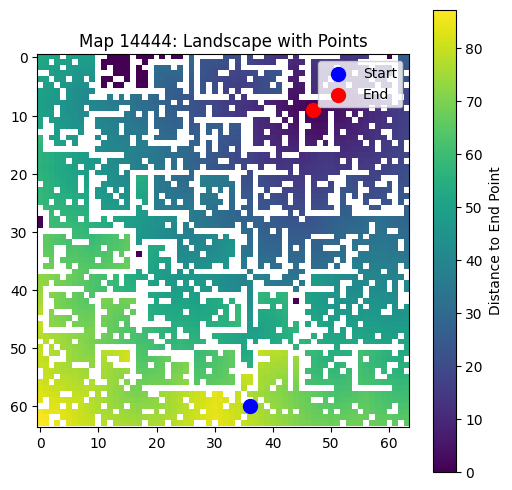

In [31]:
ind = np.random.randint(0, len(val_data))
# ind = 1
cells, positions_map, target = val_data[ind]
inputs = torch.cat([cells, positions_map], dim=0).to('cuda').unsqueeze(0)
predictions = model(inputs).detach().cpu().numpy().squeeze(0)

visualizatoin.plot_map(val_data.get_with_all(ind)[:3], ind, predictions)
visualizatoin.plot_map(val_data.get_with_all(ind)[:3], ind, target.numpy())

In [32]:
trainer.fit(lit_module, train_dataloader, val_dataloader)
wandb.finish()

You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


wandb: Currently logged in as: motatasher (motatasher-saint-petersburg-state-university). Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6]
Loading `train_dataloader` to estimate number of stepping batches.

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | UNet | 1.9 M  | train
---------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.707     Total estimated model params size (MB)
74        Modules in train mode
0         Modules in eval mode


Epoch 856:  68%|██████▊   | 339/500 [00:07<00:03, 46.19it/s, v_num=0xmy]   